# Sep Tutorial with UDF image

Same as before, we import the numpy and sep, along with matplotlib for ploting, and astropy for reading the test image

In [402]:
#import libraries numpy, sep
import numpy as np
import sep

#additionally import libraries for reading test image and displaying plots
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

#astropy instead of fitsio
from astropy.io import fits

rcParams['figure.figsize'] = [10., 8.]

After importing libraries/packages, we read in the UDF image from a FITS file

In [403]:
#read in data
hdu = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

#get image data
data1 = hdu[0].data

#use byte-swap
data1 = data1.byteswap(inplace=True).newbyteorder()

Next, the data is plotted

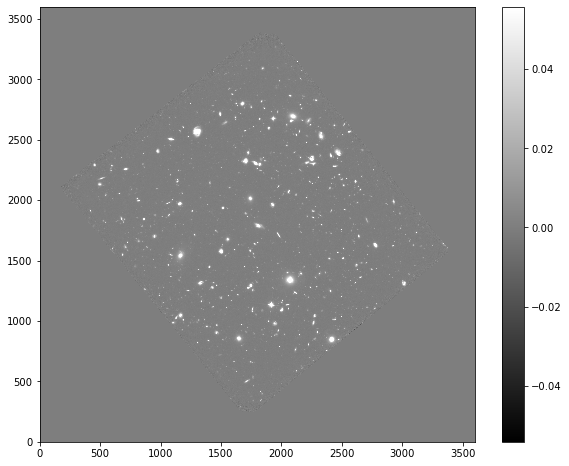

In [404]:
#show image
m, s = np.mean(data1), np.std(data1)
f = plt.figure(figsize=(10,8))
plt.imshow(data1, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()

## Background subtraction

In order to get a more accurate assesment of the data through source detection, we use sep to get rid of the background data

In [405]:
#measure background of the image
bkg = sep.Background(data1)

Now we have the variable bkg, which holds the information about the background/noise level

In [406]:
#get the 'global' mean and noise of the background
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [407]:
#evaluate background as 2-d array
bkg_image = bkg.back()
bkg_image = np.array(bkg)

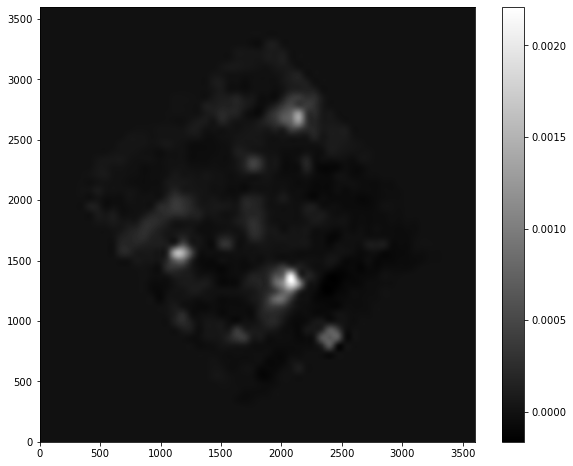

In [408]:
#show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [409]:
#evaluate background noise as 2-d array
bkg_rms = bkg.rms()

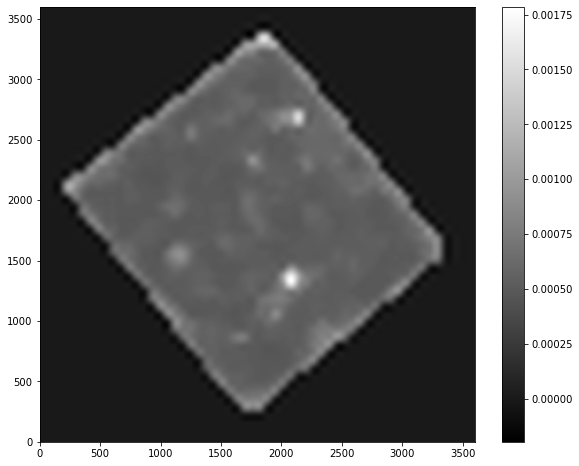

In [410]:
#show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [411]:
#subtract the background
data_sub = data1 - bkg

## Object detection

Now that we have subtracted the background data, we are able to use source detection
(the detection threshold will be a constance value of 10 as the noise level isn't very flat)

In [412]:
objects = sep.extract(data_sub, 10, err=bkg.globalrms)

In [413]:
#get the number of object detected
len(objects)

1547

Using the centroid coordinates of the objects, we can plot basic shapes over these areas and find where objects are detected

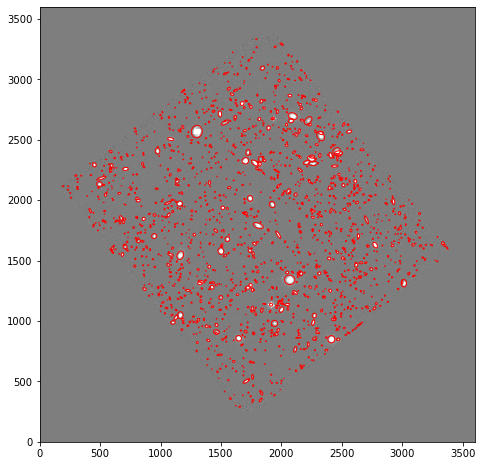

In [414]:
from matplotlib.patches import Ellipse

#plot background subtracted image
f, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

#plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]), width=6*objects['a'][i], height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. /np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

### Sources found

With a detection threshold of 10, there are 1,547 sources detected

objects has many other data fields which gives us more information on the data

In [415]:
#field options
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## Aperture photometry

the rest of the code preforms circular aperture photometry for data within a 3 pixel radius of the objects

In [416]:
#flux, fluxerr, and flag are 1-d arrays with one entry per objects
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

In [417]:
#show first 10 object results from flux and fluxerr
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i,flux[i], fluxerr[i]))

object 0: flux = 1.150696 +/- 1.072709
object 1: flux = 0.132634 +/- 0.364200
object 2: flux = 0.108431 +/- 0.329301
object 3: flux = 0.552024 +/- 0.742989
object 4: flux = 1.123947 +/- 1.060168
object 5: flux = 0.870523 +/- 0.933023
object 6: flux = 0.289554 +/- 0.538110
object 7: flux = 0.153718 +/- 0.392079
object 8: flux = 0.126304 +/- 0.355404
object 9: flux = 0.696691 +/- 0.834685


In the case of a byte order error when trying to read in the data, adding in the line:

data = data.byteswap(inplace=True).newbyteorder()

preforms byte-swap which is necessary in order to use astropy

### Histogram of fluxes

Because some the outliers of the flux data make it harder to see some of the more condensed data,
the first histogram shows all of the data and the second shows flux values > 10

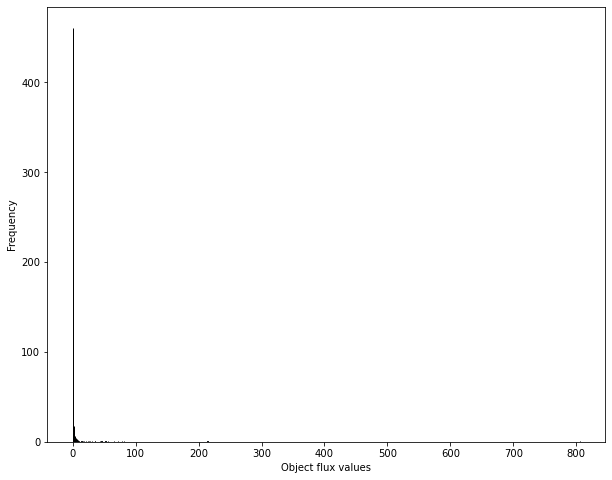

In [418]:
plt.hist(flux,bins='auto',color = "dodgerblue",edgecolor="black")
plt.ylabel("Frequency")
plt.xlabel("Object flux values")
plt.show()

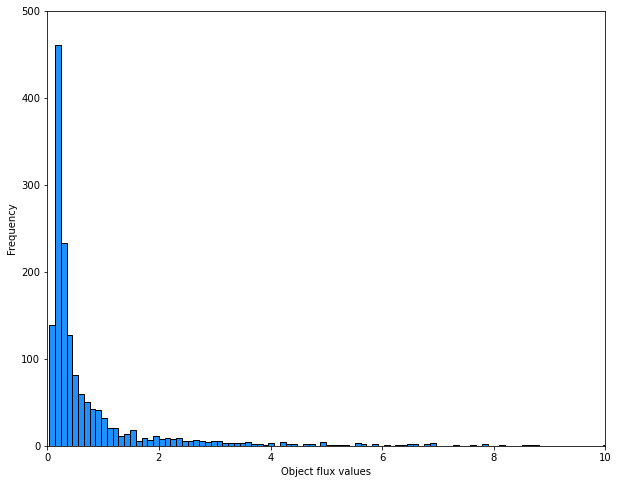

In [419]:
plt.hist(flux,bins='auto',color = "dodgerblue",edgecolor="black")
plt.axis([0,10,0,500])
plt.ylabel("Frequency")
plt.xlabel("Object flux values")
plt.show()

#### Mean, Median, and Standard Deviation

In [420]:
fm, fmd, fs = np.mean(flux), np.median(flux), np.std(flux)
print("based on the distribution of the flux data:\n")
print("the mean is: {:f}".format(fm))
print("the median is: {:f}".format(fmd))
print("the standard deviation is: {:f}".format(fs))

based on the distribution of the flux data:

the mean is: 1.895691
the median is: 0.312893
the standard deviation is: 21.747817


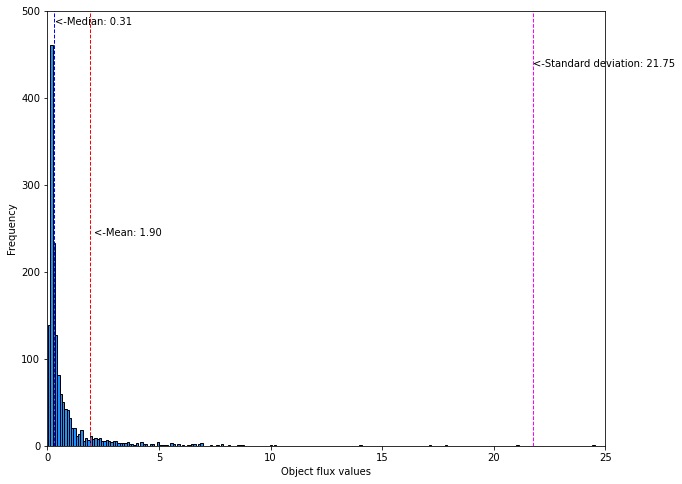

In [421]:
plt.hist(flux,bins='auto',color = "dodgerblue",edgecolor="black")

#mark mean of data
plt.axvline(fm, color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(fm*1.1, max_ylim*0.5, '<-Mean: {:.2f}'.format(fm))

#mark median of data
plt.axvline(fmd, color='blue', linestyle='dashed', linewidth=1)
plt.text(fmd*1.1, max_ylim*1.0, '<-Median: {:.2f}'.format(fmd))

#mark standard deviation of data
plt.axvline(fs, color='magenta', linestyle='dashed', linewidth=1)
plt.text(fs*1.0, max_ylim*0.9, '<-Standard deviation: {:.2f}'.format(fs))

plt.axis([0,25,0,500])
plt.ylabel("Frequency")
plt.xlabel("Object flux values")
plt.show()

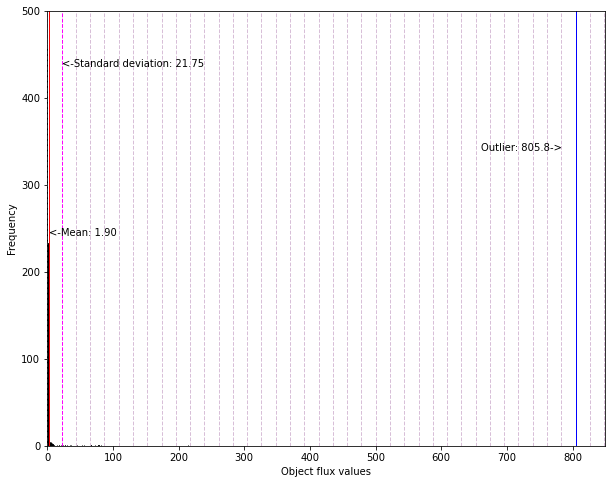

In [422]:
plt.hist(flux,bins='auto',color = "dodgerblue",edgecolor="black")

#mark mean of data
plt.axvline(fm, color='red', linestyle='solid', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(fm*1.1, max_ylim*0.5, '<-Mean: {:.2f}'.format(fm))

#mark standard deviation of data
plt.text(fs*1.0, max_ylim*0.9, '<-Standard deviation: {:.2f}'.format(fs))
for x in range(40):
    plt.axvline(fs*x, color='thistle', linestyle='dashed', linewidth=1)
    
plt.axvline(fs, color='magenta', linestyle='dashed', linewidth=1)

#mark outlier of data
out = 805.8
plt.axvline(out, color='blue', linestyle='solid', linewidth=1)
plt.text(out*.82, max_ylim*0.7, 'Outlier: {:.1f}->'.format(out))

plt.axis([0,850,0,500])
plt.ylabel("Frequency")
plt.xlabel("Object flux values")
plt.show()

#### Largest Outlier

The largest outlier, which is marked by the blue line and approximately 805.8, is about 37 standard deviations away from the mean, which is marked by the red line

# 3-color false image

Create an image of the UDF with RGB from the data f160w, f125w, and f105w. 
First we read in the data for f160w and f125w

In [423]:
#read in data
hdu2 = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")
hdu3 = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")


#get image data
data2 = hdu2[0].data
data3 = hdu3[0].data


#use byte-swap
data2 = data2.byteswap(inplace=True).newbyteorder()
data3 = data3.byteswap(inplace=True).newbyteorder()

As done in class, using the rescale_image function to get the data for image shape, min and max values which are used for the rgb values

In [424]:
def rescale_image(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m * 100.)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp, vpmin,vpmax

In [425]:
data_1_res, d1min,d1max = rescale_image(data1) #f105w
data_2_res, d2min,d2max = rescale_image(data2) #f106w
data_3_res, d3min,d3max = rescale_image(data3) #f125w

In [426]:
data_1_res[data_1_res<d1min] = d1min
data_2_res[data_2_res<d2min] = d2min
data_3_res[data_3_res<d3min] = d3min

data_1_res[data_1_res>d1max] = d1max
data_2_res[data_2_res>d2max] = d2max
data_3_res[data_3_res>d3max] = d3max

In [427]:
rgb = np.zeros((data_1_res.shape[0],data_1_res.shape[1],3))
rgb[:,:,0] = (data_2_res - d2min)/(d2max-d2min) #f160w
rgb[:,:,1] = (data_3_res - d3min)/(d3max-d3min) #f125w
rgb[:,:,2] = (data_1_res - d1min)/(d1max-d1min) #f105w


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


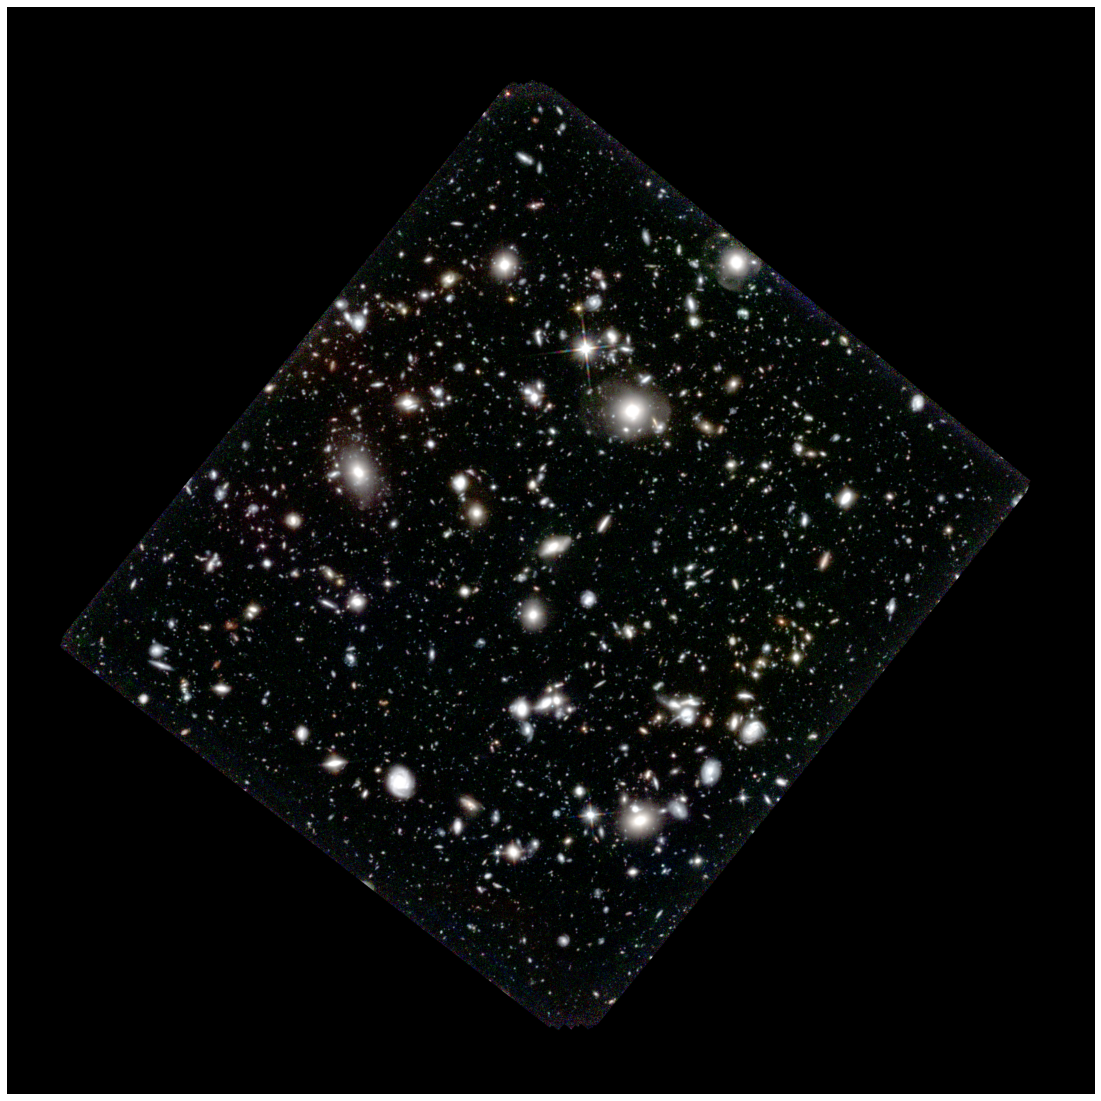

In [428]:
f,ax = plt.subplots(1,1,figsize=(20,20))
ax.axis("off")
ax.imshow(rgb)
plt.savefig("RGB-image.png", bbox_inches='tight',pad_inches=0,dpi=600)